# Gaps in the frequency domain using coloured noise

## The idea in general

The method that is demonstrated in this notebook is the $w(t)$ method. Suppose one were to observe a collection of $K$ time-domain data sets $\{d_{k}\}_{k = 0}^{K - 1}$ that will be observed with LISA, the gold-standard question is how does one analyse these data sets coherently. In this notebook, we will "impute" the data with zeros and fit a function $w(t)$, which is really a window, to stitch together two data sets $d_{1}$ and $d_{2}$. 

## Gaps do not enforce non-stationary behaviour, the user does.

If two data segments $d_{1}$ and $d_{2}$ posess stationary noise, then each of those data sets will be described by a PSD. If, one connects the two data sets by use of a window then the stationary feature is lost. This is easy to see mathematically (see the draft). The noise covariance matrix for both positive and negative frequencies will now be of the form 
$$
\Sigma_{N,ij} = \Delta f\sum_{p}\tilde{w}^{\star}(f_{i} - v_{p})\tilde{w}(f_{j} - v_{p})S_{n}(v_{p}), 
$$
Here $N$ is length of the signal in the time domain, assumed to be even. Here $\Delta f$ is the spacing between Fourier frequencies $\Delta f = 1/N\Delta t = 1/T_{\text{obs}}$. Here $\tilde{w}$ is the discrete fourier transform of the window function $w(t)$. Finally, the quantity $S_{n}(v_{p})$ is the power spectral density evaluated at some frequency component v_{p}.

For gated (windowed) data, we can build a data set simply (in the time domain) in the form 

$$D(t) = w(t)d(t) = w(t)n(t) + w(t)h(t) = N(t) + H(t).$$

Now, the covariance $\Sigma_{N} = \mathbb{E}[\boldsymbol{N}\boldsymbol{N}^{\dagger}]$ enters the likelihood and SNR formulas in the form 
$$
L(D|\theta) \propto -\frac{1}{2}(\boldsymbol{\tilde{D}} - \boldsymbol{\tilde{H}})^{T}\Sigma_{N}^{-1}(\boldsymbol{\tilde{D}} - \boldsymbol{\tilde{H}})
$$
and the optimal matched filtering SNR $\rho^{2}$ is given by
$$
\rho^{2} = 2 \boldsymbol{h}^{\dagger} \Sigma_{N}^{-1} \boldsymbol{h}.
$$

The goal of this notebook is to do the following

1. Generate a data stream with gaps in them, described using the windowing procedure.
2. Generate the noise covariance matrix using the formula above. Check it by estimating gated noise realisations. 
3. Since $\text{Det}(\Sigma_{N}) = 0$, I will demonstrate how to regularise the matrix using the SVD such that an approximate inverse can be built.
4. Compute an SNR and compare with the regularised inverse and non-regularised inverse. 
5. Compute likelihood over a grid, with noise and gaps, and show result is unbiased.
6. Average over ~ 10000 data sets with differing noise realisations. Show that result truly is unbiased with precision given by the FM... as it should be. 







In [6]:
from scipy.signal.windows import tukey
import numpy as np
import matplotlib.pyplot as plt

import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [7]:
def h(a, f0, fdot0, t, w_t = 1.0):
    """
    Inputs: Amplitude a (scalar)
            Initial frequency (scalar)
            Chirp dotf0 (scalar)
            Time (ndarray) t
            w_t window function (optional)
            
    Outputs:
            Waveform time series
    """
    
    return w_t * 3e-22*(a * np.sin((2*np.pi)*t*(f0 + fdot0 * t)))

def PowerSpectralDensity(f):
    """
    PSD obtained from: https://arxiv.org/pdf/1803.01944.pdf
    Removed galactic confusion noise.
    """        
    
    sky_averaging_constant = (20/3) # Sky Averaged 
    L = 2.5*10**9   # Length of LISA arm
    f0 = 19.09*10**-3    

    Poms = ((15e-12)**2)*(1 + ((2*1e-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (3*1e-15)**2*(1 + (4*1e-4/(f))**2)*(1 + (f/(8e-3))**4)  # Acceleration Noise 

    PSD = ((10/(3*L**2))*(Poms + (4*Pacc)/((2*np.pi*f))**4)*(1 + 0.6*(f/f0)**2)) # PSD

    return PSD

def noise_PSD(f, TDI = 'TDI1'):
    """
    Takes in frequency (f, ndarray), spits out TDI1, TDI2 A channel or Cornish noise, 
    same as E channel is equal and constant arm length approx. 
    """
    L = 2.5e9
    c = 299758492
    x = 2*np.pi*(L/c)*f
    
    Spm = (3e-15)**2 * (1 + ((4e-4)/f)**2)*(1 + (f/(8e-3))**4) * (1/(2*np.pi*f))**4 * (2 * np.pi * f/ c)**2
    Sop = (15e-12)**2 * (1 + ((2e-3)/f)**4 )*((2*np.pi*f)/c)**2
    
    S_val = (2 * Spm *(3 + 2*np.cos(x) + np.cos(2*x)) + Sop*(2 + np.cos(x))) 
    
    if TDI == 'TDI1':
        S = 8*(np.sin(x)**2) * S_val # TDI1 without GB foreground. Red noise at low f. 
    elif TDI == 'TDI2':
        S = 32*np.sin(x)**2 * np.sin(2*x)**2 * S_val # TDI2 without GB foreground. White noise at low f. 
    else:
        S = PowerSpectralDensity(f) # Cornish PSD. Horribly red. Worst case scenario. 
    return S


def zero_pad(data):
    """
    This function takes in a vector and zero pads it so it is a power of two.
    We do this for the O(Nlog_{2}N) cost when we work in the frequency domain.
    """
    N = len(data)
    pow_2 = np.ceil(np.log2(N))
    return np.pad(data,(0,int((2**pow_2)-N)),'constant')

# Build true waveform without gaps

Text(0, 0.5, 'Periodigram')

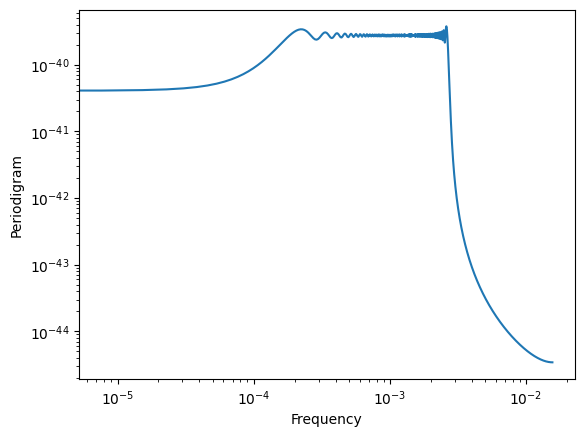

In [8]:
# Initial values plus sampling properties

a_ex = 0.5  # Parameter we want to estimate
f0_ex = 1e-4
fdot0_ex = 1e-8


tmax = 30*60*60    # Final time
fmax = 1e-7 * 1 * tmax   # maximum frequency
fs = 2*fmax                    # Sampling rate
delta_t = np.floor(0.7/fs)        # Sampling interval

t = np.arange(0,tmax,delta_t)   # Form time vector from t0 = 0 to tn = tmax
N = int(2 ** (np.ceil(np.log2(len(t)))))  # Round length of time series to a power of two.

t_pad = np.arange(0, N * delta_t, delta_t)
# Do everything for positive and negative frequencies

signal_true_pad = h(a_ex,f0_ex, fdot0_ex, t_pad)                 # Gen. true signal
freq_bin = np.fft.rfftfreq(N, delta_t)

signal_true_fft = np.fft.rfft(signal_true_pad)  # no gaps

plt.loglog(freq_bin, abs(signal_true_fft)**2)
plt.xlabel('Frequency')
plt.ylabel(r'Periodigram')

# Construct the window function

## Idea

The idea here is to build a window function such that the user specifies
- The start of the gap where $w(t_{\text{start}}) = 0$
- The end of the gap where $w(t_{\text{end}}) = 0$
- The lobe lengths as a function of time. What this means is to calculate the windowing parameter $\alpha$ such that the cosine lobe lengths equal the lobing time. Hard to explain. 
- To carefully pad this array to a power of two, so that we can use FFTs.
- Finally, use the window function to force gaps in the original signal

We are losing 10.002963841138115 % of the signal


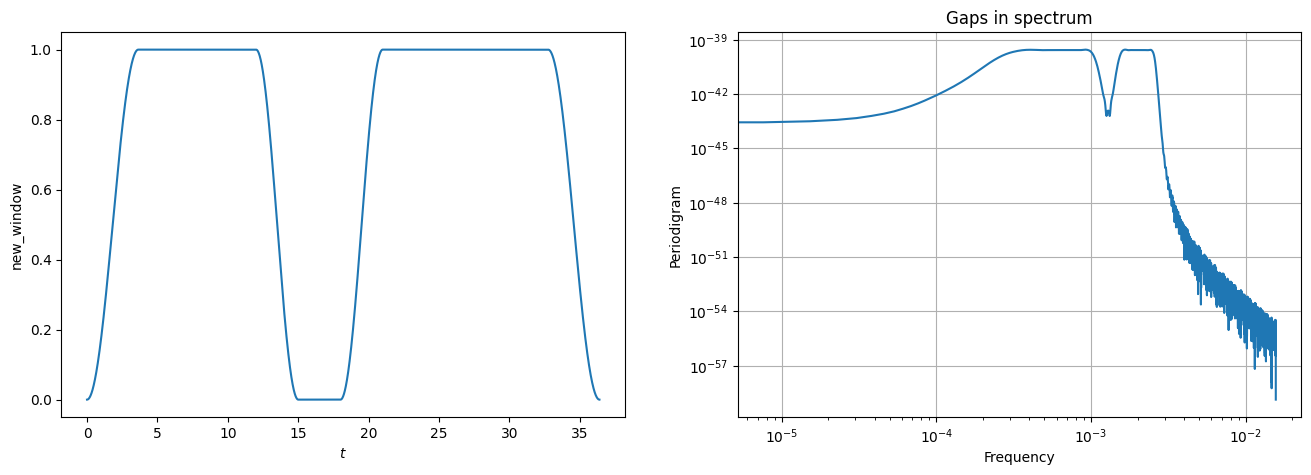

In [9]:

one_hour = 60*60

start_window = 15*one_hour          # Define start of gap
end_window = 18*one_hour          # Define end of gap
lobe_length = 3*one_hour          # Define length of cosine lobes

window_length = int(np.ceil(((end_window+lobe_length) - 
                             (start_window - lobe_length))/delta_t))  # Construct of length of window 
                                                                      # throughout the gap
alpha_gaps = 2*lobe_length/(delta_t*window_length)      # Construct alpha (windowing parameter)
                                                   # so that we window BEFORE the gap takes place.
    
window = tukey(window_length,alpha_gaps)   # Construct window

new_window = []  # Initialise with empty vector
j=0  
for i in range(0,len(t)):   # loop index i through length of t
    if t[i] > (start_window - lobe_length) and (t[i] < end_window + lobe_length):  # if t within gap segment
        new_window.append(1 - window[j])  # add windowing function to vector of ones.
        j+=1  # incremement 
    else:                   # if t not within the gap segment
        new_window.append(1)  # Just add a onne.
        j=0
        

w_t = np.pad(new_window,
           (0,N - len(new_window)),
           'constant',constant_values = 1)  # Take our window and pad with ones to use with
                                            # the noise vector.
                                            # WARNING, CHANGES ZEROS
taper = tukey(len(w_t), alpha = 0.2)

w_t *= taper

fig,ax = plt.subplots(1,2, figsize = (16,5))
ax[0].plot(t_pad/60/60,w_t);ax[0].set_ylabel(r'new_window');ax[0].set_xlabel(r'$t$')

print("We are losing",((end_window - start_window ) / (t[-1])) * 100, "% of the signal")

signal_true_gaps_pad = h(a_ex, f0_ex, fdot0_ex, t_pad, w_t = w_t)
signal_true_gaps_fft = np.fft.rfft(signal_true_gaps_pad)   # gaps

ax[1].loglog(freq_bin, abs(signal_true_gaps_fft)**2)
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel(r'Periodigram')
ax[1].set_title(r'Gaps in spectrum')
ax[1].grid()


# Compute SNR and build data set with gaps

In [10]:
freq_bin = np.fft.rfftfreq(N,delta_t)   # Generate sampling frequencies         

PSD = noise_PSD(freq_bin, "TDI1")    # Compute PSD (analytical approx given above)

max_PSD = np.argmax(PSD)  # Calculate maximum value

PSD[max_PSD] = PSD[max_PSD+1]  # Make larger (proper PSD) 

variance_f = (N * PSD/(4*delta_t))   # Compute variance of the noise (of on gapped noise) [shifted]

SNR2 = np.sum(np.abs(signal_true_fft)**2 / variance_f)   # Calculate SNR (squared) with gaps

print('SNR with no gaps',np.sqrt(SNR2))  

np.random.seed(11)
noise_imag = np.random.normal(0,np.sqrt(variance_f))   # Generate imaginary part
noise_real = np.random.normal(0,np.sqrt(variance_f))   # Generate real part
noise_f = noise_real + 1j*noise_imag

noise_f[0] = np.sqrt(2)*noise_f[0].real
noise_f[-1] = np.sqrt(2)*noise_f[-1].real

noise_t = np.fft.irfft(noise_f)   # Generate noise in time domain (TD)

noise_t_gaps = noise_t * w_t

noise_f_gaps = np.fft.rfft(noise_t_gaps)

data_f_gaps = noise_f_gaps + signal_true_gaps_fft

SNR with no gaps 53.96417892855709


# Plot the result and see that the gap is in the right place

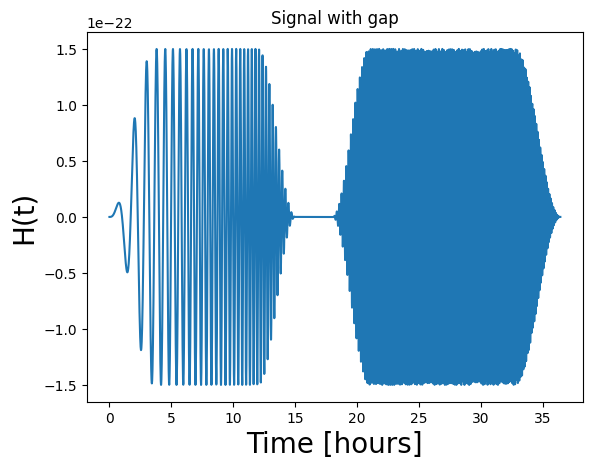

In [11]:
signal_true_w_pad_plot = w_t * signal_true_pad

plt.plot(t_pad/60/60,signal_true_w_pad_plot)
plt.xlabel(r'Time [hours]',fontsize = 20)
plt.ylabel(r'H(t)',fontsize = 20)
plt.title('Signal with gap')
plt.show()


# Closer inspection

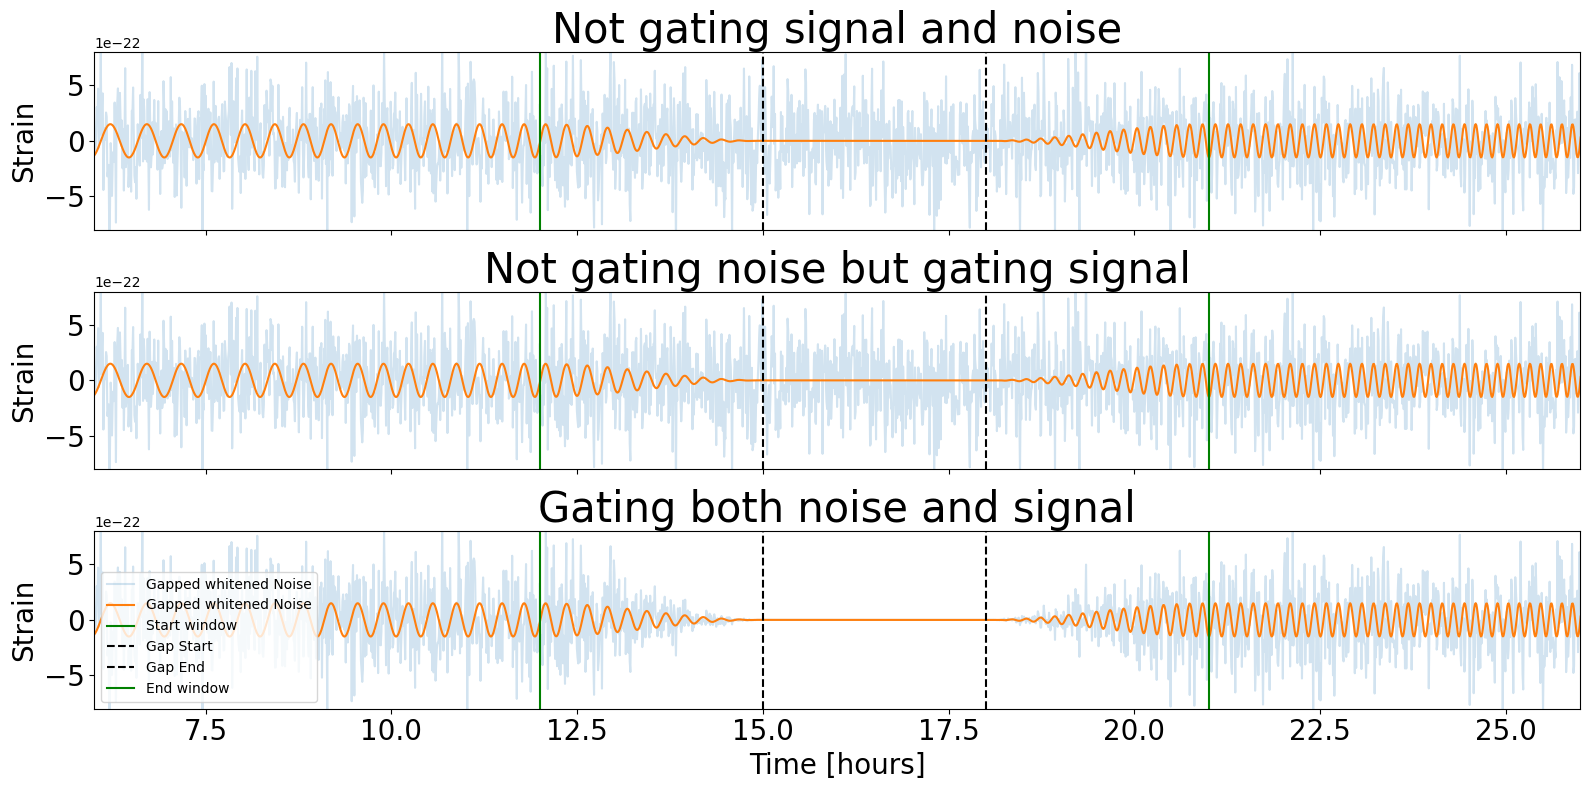

In [12]:

noise_t_gap_white = np.random.normal(0,3e-22,N)
noise_t_gap_white_window = noise_t_gap_white * w_t

fig, ax = plt.subplots(3,1, sharex = True, figsize = (16,8))
ax[0].plot(t_pad/60/60,noise_t_gap_white, alpha = 0.2)
ax[0].plot(t_pad/60/60,signal_true_w_pad_plot)

ax[1].plot(t_pad/60/60,noise_t_gap_white,alpha = 0.2, label = 'Whitened Noise')
ax[1].plot(t_pad/60/60,signal_true_w_pad_plot, alpha = 1, label = 'Signal with gap')

ax[2].plot(t_pad/60/60,noise_t_gap_white_window,alpha = 0.2, label = 'Gapped whitened Noise')
ax[2].plot(t_pad/60/60,signal_true_w_pad_plot,alpha = 1, label = 'Gapped whitened Noise')
title_label = ["Not gating signal and noise", "Not gating noise but gating signal", "Gating both noise and signal"]

ax[0].set_title(title_label[0], fontsize = 30)
ax[0].set_ylim([-6e-23,6e-23])
ax[0].set_ylabel(r'Strain',fontsize = 20)
for i in range(0,3):



    ax[i].axvline(x = (start_window - lobe_length)/60/60,color = 'green',label = 'Start window')
    ax[i].axvline(x = (start_window)/60/60, color = 'black',linestyle='dashed',label = 'Gap Start')
    ax[i].axvline(x = (end_window)/60/60, color = 'black',linestyle='dashed',label = 'Gap End')
    ax[i].axvline(x = (end_window + lobe_length)/60/60, color = 'green',label = 'End window')
    ax[i].tick_params(axis='both', which='major', labelsize=20)
    if i == 0:
        ax[2].legend(loc = 'upper right',fontsize = 15)
    ax[i].set_ylabel(r'Strain', fontsize = 20)

    ax[i].set_title(title_label[i], fontsize = 30)

    ax[i].set_ylim([-0.8e-21,0.8e-21])
    ax[i].set_xlim([6,26])

plt.legend()
ax[2].set_xlabel(r'Time [hours]',fontsize = 20)
plt.tight_layout()

# Quick sanity check on SNR

The usual formula for the SNR is given by
$$ \rho^{2} = 4\int_{0}^{\infty}\frac{|\tilde{h}(f)|^2}{S_{n}(f)}\, \text{d}f$$
where, in discretised form, this can be written as 
$$\rho^{2} = 2 \boldsymbol{h}^{\dagger}\Sigma_{n}^{-1}\boldsymbol{h}$$

with $\Sigma_{n} = N S_{n}(f_{i})\delta_{ij} / 2\Delta t$ the covariance matrix of stationary noise. We should see agreement with the SNR computed a few cells before. 

In [13]:
# Quick check of SNR using covariance matrix_stat

cov_matrix_stat = 2*np.diag(variance_f)
cov_matrix_stat_inv = np.linalg.inv(cov_matrix_stat)

SNR2_stat = np.real(2*signal_true_fft.conj() @ cov_matrix_stat_inv @ signal_true_fft)

print('SNR (squared) using stationary covariance matrix',np.sqrt(SNR2_stat))
print('Precision on a given no gaps, crude estimate',np.sqrt(a_ex**2/SNR2_stat))

SNR (squared) using stationary covariance matrix 53.964178928557075
Precision on a given no gaps, crude estimate 0.009265405495411088


# The covariance matrix for gated processes

## Details
Below is a `numba` accelerated code to compute the noise covariance matrix for a gated process. Recall the formula 

$$
\Sigma_{N,ij} = 
    \Delta f\sum_{p}\tilde{w}^{\star}(f_{i} - v_{p})\tilde{w}(f_{j} - v_{p})S_{n}(v_{p}), 
$$

The formula above was derived using the convolution theorem and so the negative frequencies are important. The general idea is that the two sided transforms for $\tilde{w}$ and $f\in(-f_{nyquist}, f_{nyquist})$ are used.

## Code

### Diagonals
I have two codes. One that constructs the noise covariance matrix on a diagonal basis (given by Sylvain). You specify how many diagonals you want, and it will build it starting from the main diagonal. It will then use the Hermitian symmetry of the matrix to determine the lower triangular piece. 

### Build element by element

I have another code that builds the matrix element by element. It's slower with only advantage is that it's a clear one to one comparison between the formula itself. 

### Outstanding issues

There are a number of computational outstanding issues below that still need addressed. 

1. First of all, the construction of the matrix is quite slow. Every element of the matrix requires $N$ floating point operations making it very expensive. My gut feeling is that the sum below can be approximated in some clever way where the Fourier domain window $\tilde{w}$ is at its maximum (zero argument). 

2. We need to determine how many diagonals are really needed, in general, to do parameter estimation. This answer will depend on the noise process. White noise i reckon we would need a mere fraction of the diagonals. For a very red noise process where leakage is a problem, I think we would need a large number since the matrix is practically dense. 

I will leave the two codes below. The first one is my naive, slow but clear implementation of the noise covariance matrix. The cost of building this matrix is $\mathcal{O}(3\cdot N^3)$. The code below is Sylvain's that is much faster than mine where it uses the convolution theorem to calculate the diagonals all using numpy operations. A few points here:

1. Although mine is slow, it is accurate all the way past machine precision. In other words, it is not impacted by the scale of the matrix.

2. Sylvain's description is much faster and better, but if the scale of the matrix is large (highly singular) I have noticed some numerical problems at the boundaries. 

In [19]:
from numba import njit,prange
@njit(parallel = True) 
def compute_covariance_slow(Cov, w_fft, PSD, Delta_f):
    '''
    Compute N x N Fourier-domain covariance matrix for windowed process

    Fourier convention: standard, \tilde{F}(f) = \int dt e^{-2 i pi f t}F(t)

    Args:
      Sn      # Values of PSD Sn(i Deltaf), i=0,...,N (size N) [frequency domain]
      w       # Values of window w(i Deltat), i=0,...,N (size N) [time domain]
      Delta_f  # Value of frequency interval 
    '''
    
    N = len(w_fft)
    w_fft_conj = w_fft.conj()
    
    # Compute the upper triangle (including diagonal)
    for i in prange(N):
        for j in range(i, N):  # Only compute upper triangle
            result = 0
            for p in range(N):
                index_i = (i - p) % N
                index_j = (j - p) % N
                index_PSD = (p + N//2) % N                
                result += w_fft[index_i] * w_fft_conj[index_j] * PSD[index_PSD]
                
            Cov[i, j] = result
            Cov[j, i] = np.conjugate(Cov[i,j])
    Cov *= Delta_f
    return Cov

In [20]:
def compute_covariance_fast(w_t,Sn, Delta_f):
    '''
    Compute N*N Fourier-domain covariance matrix for windowed process

    Fourier convention: standard, \tilde{F}(f) = \int dt e^{-2 i pi f t}F(t)

    Args:
      Sn      # Values of PSD Sn(i Deltaf), i=0,...,N-1 included (size N) [frequency domain]
      w       # Values of window w(i Deltat), i=0,...,N-1 (size N) [time domain]
      Delta_f  # Value of frequency interval 
    '''

    
    N = len(w_t)

    w_tilde = np.fft.fft(w_t)
    u_tilde = np.fft.fft(Sn)
    
    rangeN = np.arange(N)

    Sigma_tilde_w = np.zeros((N,N), dtype=complex)
    # Compute both upper and lower diagonals (in the circulant sense, with periodicity)

    for diag_index in range(N//2+1): 
        v = w_tilde * np.conj(np.roll(w_tilde, -diag_index))
        v_tilde = np.fft.fft(v)
        diag_vals = Delta_f * np.fft.ifft(u_tilde * v_tilde)
        rangeN = np.arange(N)
        Sigma_tilde_w[np.roll(rangeN, -diag_index), rangeN] = diag_vals
        # Separate index N/2, to avoid duplication
        if not diag_index==N//2:
            Sigma_tilde_w[rangeN, np.roll(rangeN, -diag_index)] = diag_vals

    return Sigma_tilde_w



# Build the covariance matrix

Now we will build the covariance matrix with gaps for three different type of noise curves.

1. The noise curve $S^{\text{TDI1}}_{n}(f)$ has a red noise wall (blows up for low frequencies). 
2. The noise curve $S^{\text{TDI2}}_{n}(f)$ is white at low frequencies but has a stronger violet noise process than TDI 1 (more spectral lines and greater noise power at high frequencies). 
3. The noise curve $S^{\text{Cornish}}_{n}(f)$ has an extremely high red noise component. This is unrealistic but really demonstrates how horrible the matrix will look if you have strong low frequency noise. This is illustrative. 

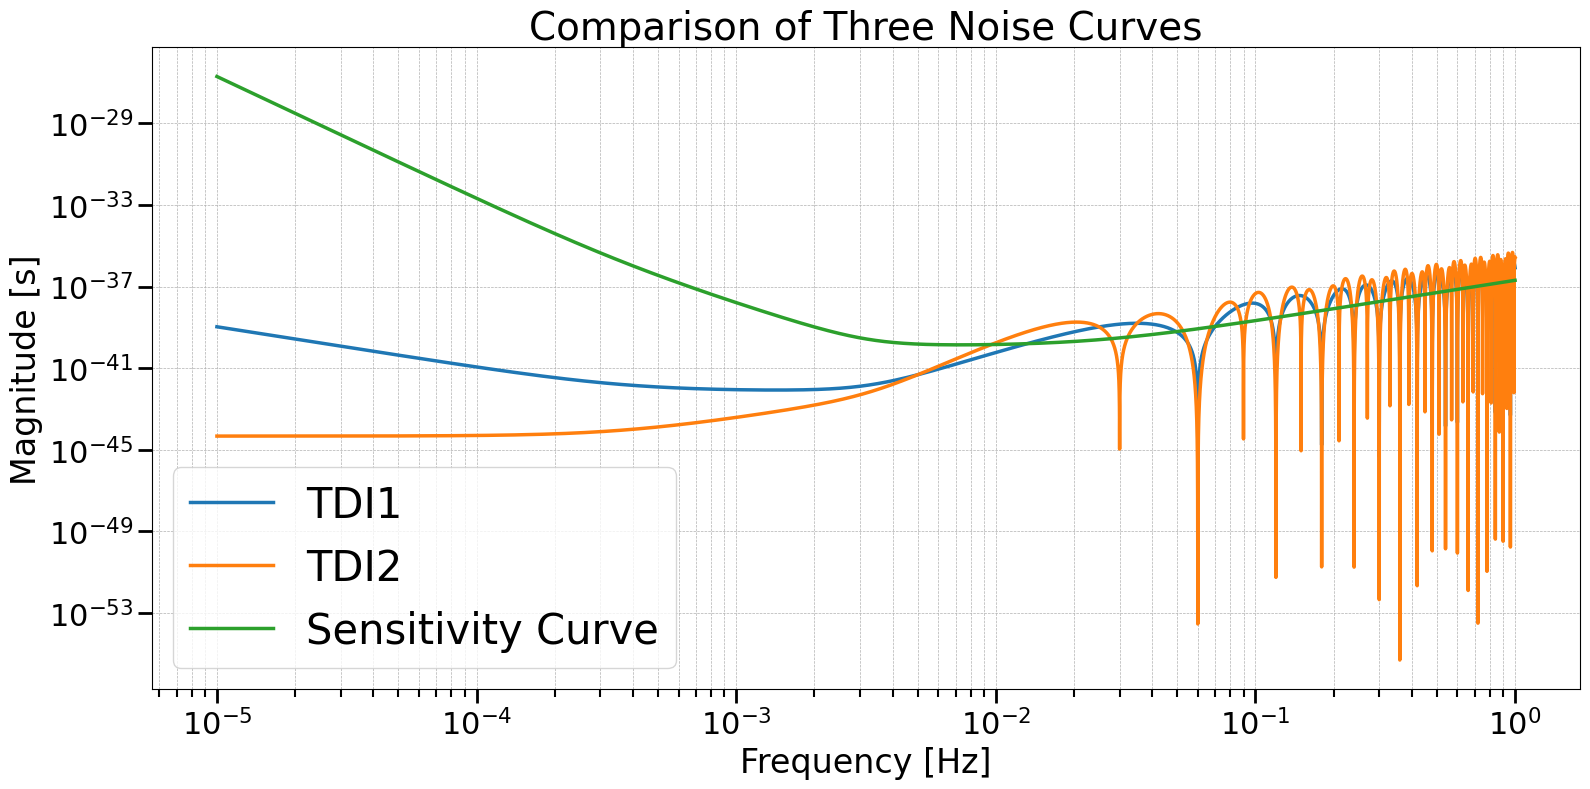

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Generate the frequency range
freq = np.linspace(0.1 * 1e-4, 1, 100000)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# Plot each PSD curve with appropriate labels
ax.loglog(freq, noise_PSD(freq, TDI="TDI1"), label="TDI1", lw = 2.5)
ax.loglog(freq, noise_PSD(freq, TDI="TDI2"), label="TDI2", lw = 2.5)
ax.loglog(freq, noise_PSD(freq, TDI="Cornish"), label="Sensitivity Curve", lw = 2.5)

# Set plot labels and title with consistent font sizes
ax.set_xlabel(r'Frequency [Hz]', fontsize=24)
ax.set_ylabel(r'Magnitude [s]', fontsize=24)
ax.set_title(r'Comparison of Three Noise Curves', fontsize=28)

# Increase tick label size and tick size
ax.tick_params(axis='both', which='major', labelsize=22, length=10, width=2)
ax.tick_params(axis='both', which='minor', labelsize=22, length=6, width=1.5)

# Add legend
ax.legend(loc="lower left", fontsize=30)

# Add grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


In [22]:
# Generate over positive and negative frequencies. Necessary for convolutions!!

delta_f = (1/(N*delta_t))  

freq_bin_pos_neg = np.fft.fftshift(np.fft.fftfreq(N,delta_t))   # Generate sampling frequencies. Two sided.        

PSD_pos_neg_TDI1 = noise_PSD(freq_bin_pos_neg, TDI = "TDI1")    # Compute PSD. Two sided.
PSD_pos_neg_TDI1[N//2] = PSD_pos_neg_TDI1[N//2 + 1]                  # Regularise PSD, set S(f = 0) = S(f = delta_f).

PSD_pos_neg_TDI2 = noise_PSD(freq_bin_pos_neg, TDI = "TDI2")    # Compute PSD. Two sided.
PSD_pos_neg_TDI2[N//2] = PSD_pos_neg_TDI2[N//2 + 1]                  # Regularise PSD, set S(f = 0) = S(f = delta_f).

PSD_pos_neg_Cornish = noise_PSD(freq_bin_pos_neg, TDI = "Cornish")    # Compute PSD. Two sided.
PSD_pos_neg_Cornish[N//2] = PSD_pos_neg_Cornish[N//2 + 1]                  # Regularise PSD, set S(f = 0) = S(f = delta_f).

w_fft = np.fft.fftshift(np.fft.fft(w_t))  # Compute fft of windowing function. Two sided.



# Compute noise covariance matrix

In [23]:
# Slow versions (mine)

print("Cov Matrix Computing TDI1")
Cov_Matrix_slow = np.zeros((N,N), dtype = complex)
Cov_Matrix_analytical_full_gap_TDI1_slow = compute_covariance_slow(Cov_Matrix_slow, w_fft, PSD_pos_neg_TDI1, delta_f)
print("Cov Matrix Computing TDI2")
Cov_Matrix_slow = np.zeros((N,N), dtype = complex)
Cov_Matrix_analytical_full_gap_TDI2_slow = compute_covariance_slow(Cov_Matrix_slow, w_fft, PSD_pos_neg_TDI2, delta_f)
print("Cov Matrix Computing Cornish")
Cov_Matrix_slow = np.zeros((N,N), dtype = complex)
Cov_Matrix_analytical_full_gap_Cornish_slow = compute_covariance_slow(Cov_Matrix_slow, w_fft, PSD_pos_neg_Cornish, delta_f)

TDI_list = ["TDI1", "TDI2", "Cornish"]
Cov_Matrices_slow = [Cov_Matrix_analytical_full_gap_TDI1_slow, Cov_Matrix_analytical_full_gap_TDI2_slow, 
                Cov_Matrix_analytical_full_gap_Cornish_slow]
Cov_Matrix_analytical_dict_slow = {}
j = 0
for label in TDI_list:
    Cov_Matrix_analytical_dict_slow[TDI_list[j]] = Cov_Matrices_slow[j]
    j+=1

Cov Matrix Computing TDI1
Cov Matrix Computing TDI2
Cov Matrix Computing Cornish


In [24]:
print("Computing TDI1")
Cov_Matrix_analytical_full_gap_TDI1_fast = compute_covariance_fast(w_t, PSD_pos_neg_TDI1, delta_f)
print("Computing TDI2")
Cov_Matrix_analytical_full_gap_TDI2_fast = compute_covariance_fast(w_t, PSD_pos_neg_TDI2, delta_f)
print("Computing Cornish")
Cov_Matrix_analytical_full_gap_Cornish_fast = compute_covariance_fast(w_t, PSD_pos_neg_Cornish, delta_f)

TDI_list = ["TDI1", "TDI2", "Cornish"]
Cov_Matrices = [Cov_Matrix_analytical_full_gap_TDI1_fast, Cov_Matrix_analytical_full_gap_TDI2_fast, 
                Cov_Matrix_analytical_full_gap_Cornish_fast]
Cov_Matrix_analytical_dict_fast = {}
j = 0
for label in TDI_list:
    Cov_Matrix_analytical_dict_fast[TDI_list[j]] = Cov_Matrices[j]
    j+=1


Computing TDI1
Computing TDI2
Computing Cornish


# Checking the matrix above

To check the gated noise covariance matrix above, we can generate a bunch of noise realisations from some stationary process (governed by $S_{n}(f)$), window these using the same function above and the compute the covariance between realisations. This will give $\Sigma_{N}^{\text{estimated}}$. This should be close in magnitude to the exact formula given above $\Sigma_{N}$. We estimate the noise covariance matrices for TDI1, TDI2 and Cornish above. 

In [ ]:
from tqdm import tqdm as tqdm

# Check the covariance matrix 
Cov_Matrix_estm_dict = {}
variance_f_dict = {}
PSD_dict = {}

PSD_list = [PSD_pos_neg_TDI1, PSD_pos_neg_TDI2, PSD_pos_neg_Cornish]

j = 0

for PSD in PSD_list:
    variance_f_iter = (N*PSD / (2*delta_t))  # Compute Variance of noise
    noise_f_gap_vec = []
    for i in tqdm(range(0,10000)):
        np.random.seed(i)
        noise_imag = np.random.normal(0,np.sqrt(variance_f_iter))   # Generate imaginary part
        noise_real = np.random.normal(0,np.sqrt(variance_f_iter))   # Generate real part
        noise_f = noise_real + 1j*noise_imag   # Compute noise (non gapped)

        noise_f[0] = np.sqrt(2)*noise_f[0].real
        noise_f[-1] = np.sqrt(2)*noise_f[-1].real

        noise_t = np.fft.ifft(noise_f)  # Compute noise in time domain
        noise_t_gaps = w_t * noise_t     # Compute noise with gaps in there
        noise_f_gap_iter = np.fft.fft(noise_t_gaps)  # Compute in frequency domain

        noise_f_gap_vec.append(noise_f_gap_iter)     

    # Estimate the noise covariance matrix given the realisations
    cov_matrix_estm_full_gap = np.dot(np.array(noise_f_gap_vec).T.conj(), np.array(noise_f_gap_vec))/len(noise_f_gap_vec)

#     cov_matrix_estm_full_gap = np.cov(noise_f_gap_vec,rowvar = False) # Estimate covariance matrix
    TDI_list = ["TDI1", "TDI2", "Cornish"]
    
    Cov_Matrix_estm_dict[TDI_list[j]] = cov_matrix_estm_full_gap
    PSD_dict[TDI_list[j]] = PSD_list[j]
    variance_f_dict[TDI_list[j]] = variance_f_iter
    j+=1

100%|██████████| 10000/10000 [00:02<00:00, 4240.56it/s]


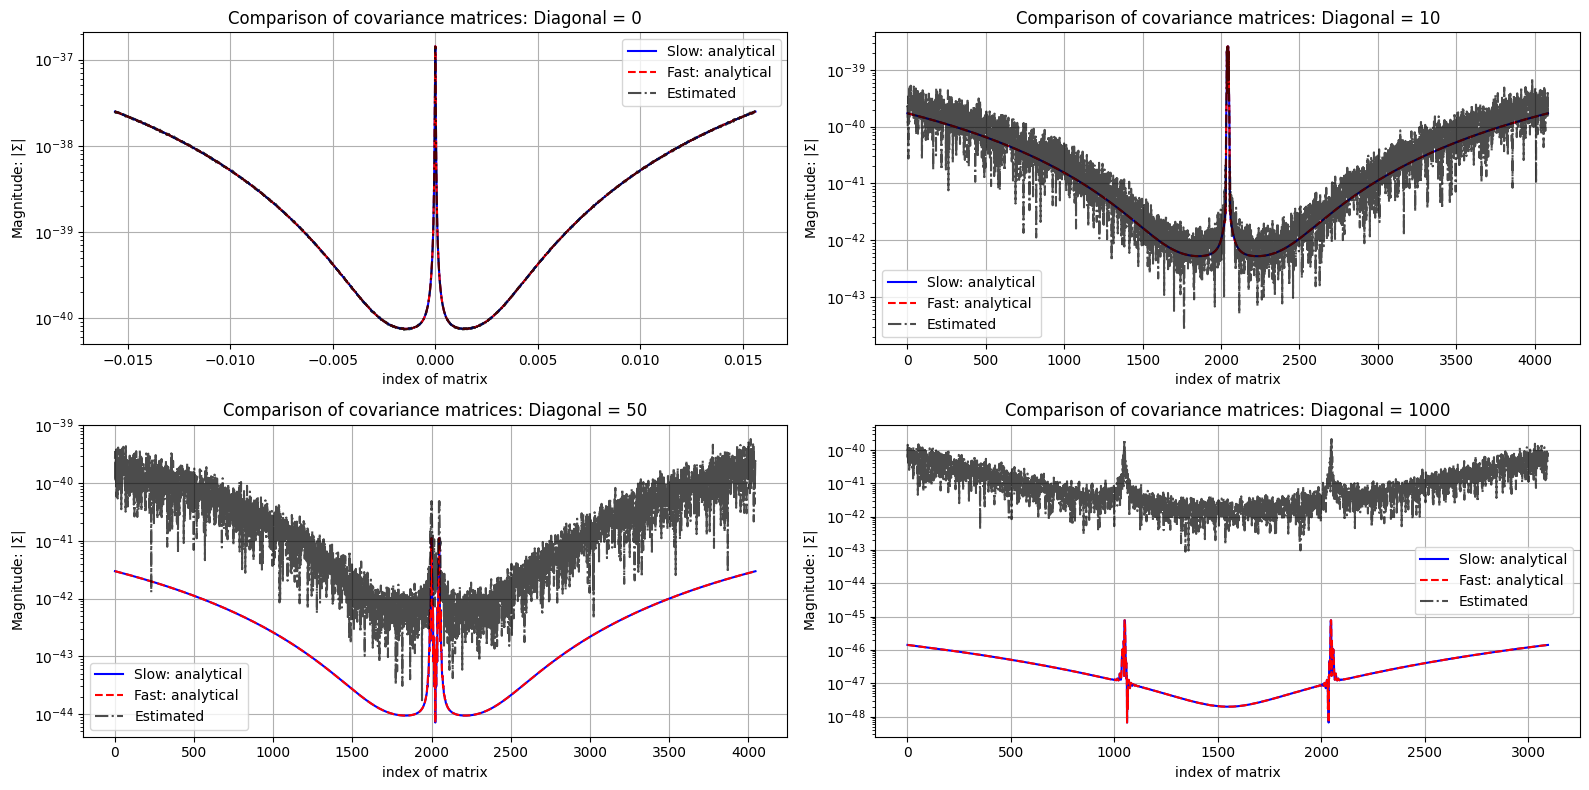

<Figure size 640x480 with 0 Axes>

In [26]:
# Check covariance matrices. Simple check of diagonals

TDI_version = "TDI1"
fig,ax = plt.subplots(2,2, figsize = (16,8))
j=0
ax[0,0].semilogy(freq_bin_pos_neg, np.abs(np.diag(Cov_Matrix_analytical_dict_slow[TDI_version],j)),c = 'blue', label = 'Slow: analytical')
ax[0,0].semilogy(freq_bin_pos_neg,np.abs(np.diag(Cov_Matrix_analytical_dict_fast[TDI_version],j)),c = 'red', linestyle = 'dashed',label = 'Fast: analytical')
ax[0,0].semilogy(freq_bin_pos_neg,np.abs(np.diag(Cov_Matrix_estm_dict[TDI_version],j)),alpha = 0.7,c = 'black', linestyle = '-.', label = 'Estimated')
ax[0,0].set_title('Comparison of covariance matrices: Diagonal = {0}'.format(j))

ax[0,1].semilogy(np.abs(np.diag(Cov_Matrix_analytical_dict_slow[TDI_version],j+10)),c = 'blue',label = 'Slow: analytical')
ax[0,1].semilogy(np.abs(np.diag(Cov_Matrix_analytical_dict_fast[TDI_version],j+10)),c = 'red', linestyle = 'dashed',label = 'Fast: analytical')
ax[0,1].semilogy(np.abs(np.diag(Cov_Matrix_estm_dict[TDI_version],j+10)),alpha = 0.7,c = 'black', linestyle = '-.',label = 'Estimated')
ax[0,1].set_title('Comparison of covariance matrices: Diagonal = {0}'.format(j+10))

ax[1,0].semilogy(np.abs(np.diag(Cov_Matrix_analytical_dict_slow[TDI_version],j+50)),c = 'blue',label = 'Slow: analytical')
ax[1,0].semilogy(np.abs(np.diag(Cov_Matrix_analytical_dict_fast[TDI_version],j+50)),c = 'red', linestyle = 'dashed',label = 'Fast: analytical')
ax[1,0].semilogy(np.abs(np.diag(Cov_Matrix_estm_dict[TDI_version],j+50)),alpha = 0.7,c = 'black', linestyle = '-.',label = 'Estimated')
ax[1,0].set_title('Comparison of covariance matrices: Diagonal = {0}'.format(j+50))

ax[1,1].semilogy(np.abs(np.diag(Cov_Matrix_analytical_dict_slow[TDI_version],j+1000)),c = 'blue',label = 'Slow: analytical')
ax[1,1].semilogy(np.abs(np.diag(Cov_Matrix_analytical_dict_fast[TDI_version],j+1000)),c = 'red', linestyle = 'dashed', label = 'Fast: analytical')
ax[1,1].semilogy(np.abs(np.diag(Cov_Matrix_estm_dict[TDI_version],j+1000)),alpha = 0.7,c = 'black', linestyle = '-.',label = 'Estimated')
ax[1,1].set_title('Comparison of covariance matrices: Diagonal = {0}'.format(j+1000))

for i in range(0,2):
    for j in range(0,2):
        ax[i,j].set_xlabel(r'index of matrix')
        ax[i,j].set_ylabel(r'Magnitude: $|\Sigma|$')
        ax[i,j].legend()
        ax[i,j].grid()
plt.tight_layout()
plt.show()
plt.clf()

# Plot the matrices

Notice here that we have a band diagonal matrix. When w(t) is rectangular window, this will maximise leakage effects and thus the band-diagonal nature of the matrix is less preserved. Notice that the estimated matrix and approximate matrix agree well. Change the variable `TDI_version` to see how the difference matrices look when you look at each noise curve. 

## Summary of results

1. TDI1 gives a band diagonal matrix but there is leakage at low frequencies. This makes the band diagonal approach a little rough.
2. TDI2 is perfectly band diagonal.
3. Cornish noise is a total mess. Impossible to exploit any structure aside from the fact that the matrix is Hermitian. A clear result here is that TDI2 is favourable. 

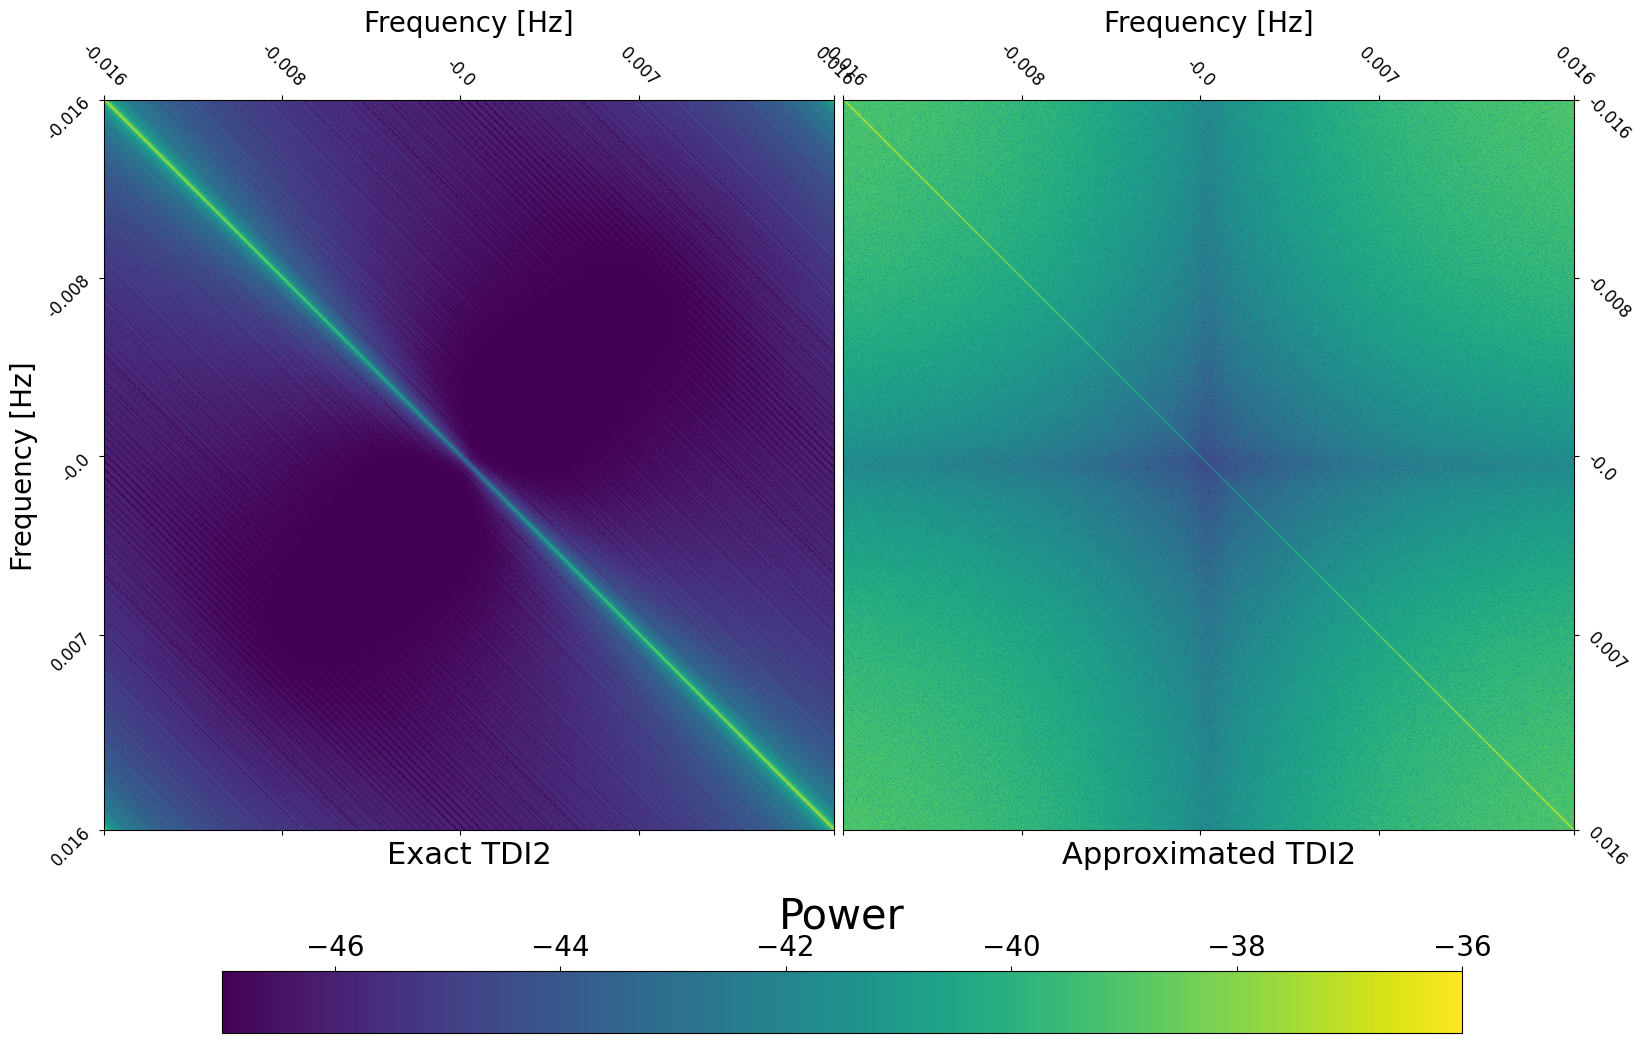

In [27]:
# Plot the matrices
# TDI_version = "TDI1"
TDI_version = "TDI2"
# TDI_version = "Cornish"

freq_bin_pos_neg = np.fft.fftshift(np.fft.fftfreq(N, delta_t))
title_label = [r'Exact {}'.format(TDI_version), r'Approximated {}'.format(TDI_version)]

fig,ax = plt.subplots(1,2,figsize = (16,8))

mat_TDI1 = ax[0].matshow(np.log10(np.abs(Cov_Matrix_analytical_dict_slow[TDI_version])), vmin = -47, vmax = -36)
mat_cornish = ax[1].matshow(np.log10(np.abs(Cov_Matrix_estm_dict[TDI_version])), vmin = -47, vmax = -36)

cbar = fig.colorbar(mat_cornish, ax=ax, location='top',anchor=(0, -25), 
             shrink=1)
cbar.set_label(label = r'Power', fontsize = 30)
cbar.ax.tick_params(labelsize=20) 

ticks = [0, 1000, 2000, 3000, 4095]
freq_ticks = [freq_bin_pos_neg[item] for item in ticks]

ax[1].yaxis.tick_right()

for i in range(0,2):
    ax[i].set_xticks(ticks, np.round(freq_ticks,3),fontsize = 12, rotation = 315)
    ax[0].set_yticks(ticks, np.round(freq_ticks,3),fontsize = 12,rotation = 45)
    ax[1].set_yticks(ticks, np.round(freq_ticks,3),fontsize = 12,rotation = 315)
    ax[i].set_title('Frequency [Hz]', fontsize = 20)
    ax[0].set_ylabel('Frequency [Hz]', fontsize = 20)
    ax[i].set_xlabel(title_label[i],fontsize = 22)
plt.tight_layout()  
plt.show()

# Regularising the matrix

## Non invertible matrix (from paper)

Let $\mathcal{M} = \{t_{0},t_{1},\ldots,t_{M-1}\}$ denote the set of $M$ time bins such that the gated noise $N(t_{i}) = 0$ for $i \in [0,\ldots,M-1]$. Using the inverse Fourier transform,  
$$
N(t_{i}) \propto \sum_{k}\hat{N}(f_{k})\exp(2\pi i f_{k}t_{i}) = \hat{\boldsymbol{N}}^{T}\boldsymbol{a}_{i}.
$$
with vectors $\boldsymbol{\hat{N}} = \{\hat{N}(f_{k})\}_{k = \lfloor -N/2 \rfloor}^{\lfloor N/2 + 1\rfloor}$ and $\boldsymbol{a}_{i} = \{\exp(2\pi i f_{k}t_{i})\}_{k = \lfloor -N/2 \rfloor}^{\lfloor N/2 + 1\rfloor}$ defined at a time bin $t_{i}$. 
We can compute the time domain noise-covariance matrix $\forall t_{i},t_{j} \in \mathcal{M}$,
\begin{align}
\langle N(t_{i})N(t_{j})^{\star} \rangle &\propto \langle \hat{\boldsymbol{N}}^{T}\boldsymbol{a}_{i}(\hat{\boldsymbol{N}}^{T}\boldsymbol{a}_{j})^{\star}\rangle  \\ &= \boldsymbol{a}_{i}^{T}\langle \hat{\boldsymbol{N}}\hat{\boldsymbol{N}}^{\dagger} \rangle \boldsymbol{a}_{j}^{\star} \nonumber \\
&= \boldsymbol{a}_{i}^{T} \Sigma_{N}  \boldsymbol{a}_{j}^{\star} \label{Data_gaps_eq:Zero_Covariance_Gap_Time}\, .
\end{align}
Notice that $\forall t_{i},t_{j} \in \mathcal{M}$, we have that $N(t_{i}) = N(t_{j}) = 0$ and so the time domain noise-covariance must be zero within the gated segment. We deduce that $\Sigma_{N}\boldsymbol{a}_{j}^{\star} = 0 \Longleftrightarrow \boldsymbol{a}_{j}^{\star} \in \text{Null}(\Sigma_{N})$ for all $t_{j} \in \mathcal{M}$. Since no component of $\boldsymbol{a}_{j}^{\star}$ is zero, we deduce from $\Sigma_{N}\boldsymbol{a}_{j}^{\star} = \lambda \boldsymbol{a}_{j}^{\star} = 0$ that there must be an $M$ dimensional subspace where the eigenvalues $\lambda = 0$. Since there exist at most $M$ eigenvalues $\lambda = 0$, the matrix $\Sigma_{N}$ is non-invertible and thus degenerate.  

This demonstrates that the matrix cannot be invertible if there are gaps in the data and our gap treatment is with window functions. The approach we use to get past this is to regularise the matrix using the SVD decomposition and to "remove" the singular values that correspond to the gap segment. This is a standard algorithm in Numerical Recipes by Press, Teukolsky, Vetterling. After the SVD, we decide how many singular values to remove based on the window function. For extra stability, we actually remove the number of singular values that correspond to points where $w(t) < \text{tol}$ for some tolerance.

## Outstanding issues

- The SNR is not unique here. I can tweak the tolerance and find different values of SNR. I usually remove the same number of singular values as zero values in the window (divided by 2, since we are dealing with positive transforms). 
- It's expensive as hell. This is more expensive than building the matrix since we need to compute an SVD. 
- There might be better ways around this. Perhaps we can solve systems of linear equations? The fact that the matrix for TDI1/TDI2 is sparse should be better exploited. The inverse of a band-diagonal matrix is not necessarily band diagonal. 



In [28]:
def regularise_matrix(Cov_Matrix, window, tol = 0.01, block_matrix = False, check_results = False):
    """
    Inputs: Cov_Matrix : Noise covariance matrix
            window : window function
            tol (arg): Essentially fraction of singular values to ignore in window
            check_results (bool): If True, then print out useful debugging techniques

    Outputs: Cov_Matrix_reg_inv : Regularised inverse
    """

    U,S,Vh = np.linalg.svd(Cov_Matrix)           # Compute SVD
    matrix_length = len(S)

    N_remove = len(np.argwhere(window < tol))
        
    N_retain = len(S) - N_remove                 # Compute number of singular values to retain
    S_inv = S**-1                                # Compute inverse of singular matrix. 
    
    S_inv_regular = []
    for i in range(0,matrix_length):
        if i >= N_retain: 
            S_inv_regular.append(0)              # Set infinite singular values to zero. 
        else:
            S_inv_regular.append(S_inv[i])
    Cov_Matrix_reg_inv = Vh.T.conj() @ np.diag(S_inv_regular) @ U.conj().T
    np.fill_diagonal(Cov_Matrix_reg_inv, np.real(np.diag(Cov_Matrix_reg_inv))) # Force diagonal to be real. 

    if check_results == True:
        indices_remove = np.arange(N_retain, matrix_length, 1)
        
        plt.semilogy(S, '*', c = 'blue', label = 'non truncated')
        plt.semilogy(S[0:N_retain], 'o', c = 'red', label = 'truncated')
        plt.semilogy(indices_remove, S[N_retain:], c = 'cyan', alpha = 0.1, linestyle = '-.', label = 'Removed')
        
        plt.xlabel(r'Index of matrix', fontsize = 16)
        plt.ylabel(r'Singular Value of SVD', fontsize = 16)
        plt.title(r'Analysis of singular matrix', fontsize = 16)
        plt.legend(loc = "lower left", fontsize = 16)
        plt.grid()
#         plt.clf()
        
        print("We remove {} singular values".format(N_remove))
    return Cov_Matrix_reg_inv 

We remove 989 singular values


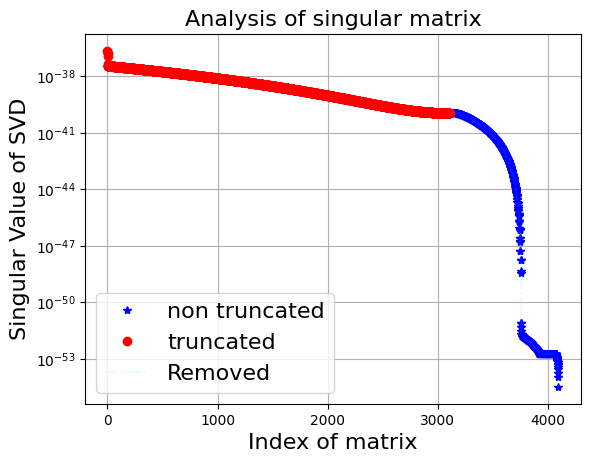

In [29]:
# Regularise for TDI1
tol = 0.4
Cov_Matrix_Gated_Inv_Regularised = regularise_matrix(Cov_Matrix_analytical_dict_slow["TDI1"], 
                                                     w_t, 
                                                     tol = tol, check_results = True)

Cov_Matrix_Gated_Inv_Non_Regularised = np.linalg.inv(Cov_Matrix_analytical_dict_fast["TDI1"])

# Pseudoinverse

## What is a pseudoinverse

The intent of a pseudoinverse is to approximate the inverse of a non-invertable matrix. Suppose that $A$ is a matrix that is non-invertible, then the Pseudo inverse $A^{+}$ is the matrix such that 

\begin{align}
\text{Condition 1} &\Longrightarrow (AA^{+})A = A \\
\text{Condition 2} &\Longrightarrow (A^{+}A)A^{+} = A^{+} \\
\text{Condition 3} &\Longrightarrow (A^{+}A)^{\dagger} = (A^{+}A) \\
\text{Condition 4} &\Longrightarrow (AA^{+})^{\dagger} = (AA^{+}) \\
\end{align}

This generalises the usual inverse $A^{-1}$ such that $A A^{-1} = A^{-1}A = I$ for $I$ the identity matrix. We can check the validity of our inverse below

# Compute the SNR

Here we comput the SNR in four different ways 

1. Computing the SNR when there are no gaps and assuming the stationary covariance matrix. 
2. Computing the SNR when there are gaps and assuming the stationary covariance matrix.
3. Computing the SNR when there are gaps and assuming the non-regularised gapped covariance matrix.
4. computing the SNR when there are gaps and assuming the regularised gapped covariance matrix. 

## Results

We see immediately that the matrix that has not been regularised is numerically unstable. The matrix that has been regularised is numerically stable and giving reasonable results. The regularised results are a litte sensitive to the "tol" but not horribly, a difference, perhaps, in ~ 2\% to the SNR.

In [30]:
signal_true_fft = np.fft.fftshift(np.fft.fft(signal_true_pad))  # no gaps
signal_true_gaps_fft = np.fft.fftshift(np.fft.fft(signal_true_gaps_pad)) # with gaps
cov_matrix_stat_inv = np.linalg.inv(np.diag(N * PSD_dict["TDI1"] / (1 * delta_t)))


In [31]:
SNR2_w_no_gaps_stat_cov = 2*np.real(signal_true_fft.conj() @ cov_matrix_stat_inv @ signal_true_fft)
SNR2_w_gaps_stat_cov = 2*np.real(signal_true_gaps_fft.conj() @ cov_matrix_stat_inv @ signal_true_gaps_fft)

SNR2_w_gaps_non_regularised = 2*np.real(signal_true_gaps_fft.conj() @ 
                                        Cov_Matrix_Gated_Inv_Non_Regularised @ 
                                        signal_true_gaps_fft)

SNR2_w_gaps_regularised = 2*np.real(signal_true_gaps_fft.conj() @ 
                                    Cov_Matrix_Gated_Inv_Regularised @ 
                                    signal_true_gaps_fft)

print('SNR using stationary covariance matrix without gaps',np.sqrt(SNR2_w_no_gaps_stat_cov))
print('SNR using stationary covariance matrix with gaps',np.sqrt(SNR2_w_gaps_stat_cov))
print("")
print('SNR using my original covariance matrix with gaps',np.sqrt(SNR2_w_gaps_non_regularised))
print('SNR using regularised covariance matrix with gaps',np.sqrt(SNR2_w_gaps_regularised))

# Solve the system via system of equations. Faster and numerically more stable. 



SNR using stationary covariance matrix without gaps 53.96417572303779
SNR using stationary covariance matrix with gaps 45.34791965468081

SNR using my original covariance matrix with gaps 48.53174725960514
SNR using regularised covariance matrix with gaps 42.31553705699437


# The real test: Parameter Estimation

The real way to test whether your noise covariance matrix is actually consistent with the noise realisation in your data stream is to perform some facet of parameter estimation. It doesn't matter whether it is maximum likelihood estimation or full Bayesian inference on a large parameter space, the thing that matters are that gated noise realisations are present. 

If there is no noise, then, assuming there are no mis-modelling errors in your waveform templates, there will be no bias. However, if there is noise, then this noise will enforce a statistical fluctuation away from your true parameters, inducing the recovered parameters. Such a fluctuation is not a bias, since the average of all fluctuations should equal the true parameters. We will show all of this below.

# Define the Data

In [34]:
# Average over data sets
def gen_gapped_noise(seed_no, variance_noise_f, w_t):
    np.random.seed(seed_no)
    
    noise_imag = np.random.normal(0,np.sqrt(variance_noise_f))   # Generate imaginary part
    noise_real = np.random.normal(0,np.sqrt(variance_noise_f))   # Generate real part
    noise_f = noise_real + 1j*noise_imag

    noise_f[0] = np.sqrt(2)*noise_f[0].real
    noise_f[-1] = np.sqrt(2)*noise_f[-1].real

    noise_t = np.fft.ifft(noise_f)   # Generate noise in time domain (TD)

    noise_t_gaps = noise_t * w_t

    noise_f_gaps = np.fft.fft(noise_t_gaps)

    return noise_f_gaps
    

def build_data(seed_no, variance_noise_f, w_t, zero_noise = False):


    if zero_noise == False:
        noise_f_gaps = gen_gapped_noise(seed_no, variance_noise_f, w_t)
        return (noise_f_gaps + signal_true_gaps_fft)
    else:
        return (signal_true_gaps_fft)
    

# Define the likelihood

Recall that we will use a likelihood of the form
$$\log \mathcal{L} \propto - \frac{1}{2}(\boldsymbol{D} - \boldsymbol{H})^{\dagger} \Sigma_{N} (\boldsymbol{D} - \boldsymbol{H}) $$

where $\Sigma_{N}$ is a regularised inverse. If we did not use this regularised inverse we would be in for a bad time. Now, if the noise covariance matrix $\Sigma_{N}$ is truly consistent with the noise in the data stream, it's easy to show that for no signal present: 

$$\log \mathcal{L} \propto - \frac{1}{2}\boldsymbol{N}^{\dagger} \Sigma_{N} \boldsymbol{N} \approx -N/2$$

for N the number of data points. This is easier seen in the statinoary limit where 

\begin{align}
\log \mathcal{L} &\propto -\frac{1}{2}\boldsymbol{n}^{\dagger} \Sigma_{n} \boldsymbol{n} \\
&\approx -\Delta t \sum_{i} \frac{|\hat{n}(f_{i})|^2}{N S_{n}(f_{i})} \\
&\approx -\Delta t \sum_{i=-N/2}^{N/2 - 1} \frac{\delta_{ij}S_{n}(f_{i})N/(2\Delta t)}{NS_{n}(f_{i})} \\
&\approx -(N/2), \quad \text{for large N}
\end{align}
This is a horribly rough approximation but will tell us if we are in the right ball park. We check this below.


In [35]:
noise_f_gaps_TDI1 = gen_gapped_noise(1110003, variance_f_dict["TDI1"], w_t)
noise_f_gaps_TDI_Cornish= gen_gapped_noise(117193, variance_f_dict["Cornish"], w_t)


    
    # Compute likelihood
log_like_val_TDI1 = -0.5 * np.real(noise_f_gaps_TDI1.conj() @ 
                            Cov_Matrix_Gated_Inv_Regularised @ 
                            noise_f_gaps_TDI1)

log_like_val_Cornish = -0.5 * np.real(noise_f_gaps_TDI_Cornish.conj() @ 
                            Cov_Matrix_Gated_Inv_Regularised @ 
                            noise_f_gaps_TDI_Cornish)
    
    
print("Number of data points / 2 = ",-N/2)
print("For TDI1, we recover for the noise log-likelihood : ",log_like_val_TDI1)
print("For Cornish noise but with TDI1 matrix, we recover for the noise log-likelihood : ",log_like_val_Cornish)
print("Messy as heck")

Number of data points / 2 =  -2048.0
For TDI1, we recover for the noise log-likelihood :  -1534.438208354281
For Cornish noise but with TDI1 matrix, we recover for the noise log-likelihood :  -4929608666282.761
Messy as heck


# Plot likelihood on grid of amplitudes

## The goal

What we want to see is a Gaussian distribution peaked on a value that is within the $1\sigma$ credible interval of the true parameter. This means that everything is consistent. 

## What we do not want to see

A distribution peaked on a value far away from the true parameter if there are noise realisations. This means that the noise is inconsistent with the noise covariance matrix.

## A useful check

A useful theoretical check is the Fisher matrix on the amplitude. A short calculation shows that $\Delta a = a/\rho$ and so we have something to check our likelihood against. 

In [36]:
# Compute estimate for Fisher matrix on amplitude
precision_amp = a_ex / np.sqrt(SNR2_w_gaps_regularised) 

# Define range of amplitude values
a_range = np.arange(0.42, 0.58, 0.001)
a_range[-1] = a_ex
a_range = np.sort(a_range) 

data_f_gaps_seed = build_data(192003, variance_f_dict["TDI1"], w_t, zero_noise = False)

llike_vec = []
for amp in a_range:
    signal_prop_gaps = h(amp, f0_ex, fdot0_ex, t_pad, w_t = w_t)   # Generate proposed signal
    signal_prop_gaps_fft = np.fft.fftshift(np.fft.fft(signal_prop_gaps))   # Frequency domain
    
    data_diff = data_f_gaps_seed - signal_prop_gaps_fft 
    
    # Compute likelihood
    log_like_val = -0.5 * np.real(data_diff.conj() @ 
                                Cov_Matrix_Gated_Inv_Regularised @ 
                                data_diff)
    llike_vec.append(log_like_val)

# Plot the results

Text(0.5, 1.0, 'With gaps and Noise')

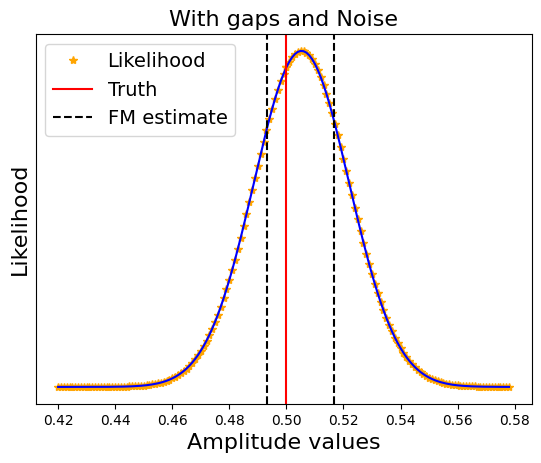

In [37]:
llike_vec_norm = np.array(llike_vec) - np.max(llike_vec) # Normalise, otherwise exponentiating gives silly results

like_norm_array = np.exp(np.array(llike_vec_norm))
max_index = np.argmax(like_norm_array)
a_ML = a_range[max_index] # Compute MLE

plt.plot(a_range,like_norm_array, '*', c = 'orange',label = 'Likelihood')
plt.plot(a_range,like_norm_array, c = 'blue')
plt.axvline(x = a_ex, label = 'Truth', c = 'red')
plt.axvline(x = a_ML - precision_amp, label = 'FM estimate', c = 'black', linestyle = '--')
plt.axvline(x = a_ML + precision_amp, c = 'black', linestyle = '--')
plt.legend(fontsize = 14)
plt.yticks([])
plt.ylabel(r'Likelihood', fontsize = 16)
plt.xlabel(r'Amplitude values', fontsize = 16)
plt.title(r'With gaps and Noise', fontsize = 16)



# Check overall consistency. 

In the above code, we have just checked one noise realisation. The best way to check whether the noise covariance matrix is consistent with the (data based) noise process is to do parameter estimation over multiple different data streams with different nosie realisations. In theory, in the high SNR limit, the distribution of the recovered parameters should be centered on the true parameter with $1\sigma$ deviation given by any of the single PE runs on a single data stream. Or, in other words, forecasted by the Fisher matrix. 

## A useful formula

\begin{equation}
\begin{aligned}
\mathbb{E}_{N}[\widehat{\Delta \theta}^{i}_{\text{bf}}\widehat{\Delta \theta}^{j}_{\text{bf}}] &= 2(\Gamma^{-1})_{(\Sigma)}^{ik}   \text{Re}\left(\partial_{k}\boldsymbol{\hat{H}} \Sigma^{-1}\Sigma_{N}\Sigma^{-1}\partial_{p}\boldsymbol{\hat{H}}\right)(\Gamma^{-1})_{(\Sigma)}^{pj}\, , \\
\end{aligned}
\end{equation}
Here $\Sigma$ is the noise covariance matrix that appears in the likelihood and $\Sigma_{N}$ is the noise covariance matrix that describes the true gated noise process defining the data stream. If, $\Sigma = \Sigma_{N}$, then we recover

\begin{aligned}
\mathbb{E}_{N}[\widehat{\Delta \theta}^{i}_{\text{bf}}\widehat{\Delta \theta}^{j}_{\text{bf}}] &= (\Gamma^{-1})^{ij}
\end{aligned}
\end{equation}
stating that the parameter covariance matrix is equivalent to the inverse Fisher matrix. 

Now, given that we just want to estimate the amplitude of a toy signal

$$ y = a\sin(2\pi f t) $$, 

it is possible to do this analytically. We want to find the value of $A$ that maximises the likelihood such that 

$$(\partial_{a}h | d - h)_{\Sigma} = 0.$$

We remind the reader that the inner product (\cdot | \cdot) uses the model covariance matrix in the likelihood. 

Defining $\bar{h} = h/a$, It can be shown that the value 

$$ A = \frac{(\bar{h}|d)_{\Sigma}}{(\bar{h}|\bar{h})_{\Sigma}}$$

maximises the likelihood. A quick calculation shows that the mean and variance of this result are equivalent to

\begin{equation}
\mathbb{E}[A] = \frac{(\bar{h}|h_{e})}{(\bar{h}|\bar{h})} \quad \text{and} \quad \text{Var}[A] = \frac{1}{(\bar{h}|\bar{h})} = \frac{a^2}{\rho^2}
\end{equation}
<!-- We will check this below by performing the following algorithm.

1. Generate N data sets with different gated noise realisations.
2. For every data set, Plot the likelihood on a grid of values and find the maximum likelihood estimate. Store this to a list. 
3. Continue until N maximum likelihood estimates have been found.
4. Plot the histogram of recovered parameters. It should be centered on the true amplitude with uncertainty given by the Fisher information matrix.  -->

In [38]:
# Instead of plotting the likelihood over a grid of values, do this analytically.
max_data_sets = 100000
MLE_values = []
# Compute unnormalised windowed template
unnormalised_template = h(1,f0_ex, fdot0_ex, t_pad, w_t = w_t)

# Compute positive side fast fourier transform
unnormalised_template_gaps_fft = np.fft.fftshift(np.fft.fft(unnormalised_template))
    
# Copmute denominator, independent of data
denominator = 2*np.real((unnormalised_template_gaps_fft.conj() @ 
               Cov_Matrix_Gated_Inv_Regularised @ 
               unnormalised_template_gaps_fft))

# Pre compute part of numerator. Covariance + signal (unnormalised) is known
post_mult = (Cov_Matrix_Gated_Inv_Regularised @ unnormalised_template_gaps_fft)
                
for seed_number in tqdm(range(0,max_data_sets)):
    
    data_f_gaps_seed = build_data(seed_number, variance_f_dict["TDI1"], w_t)  # Generate gated noise 

    numerator = 2*np.real(np.dot(data_f_gaps_seed.conj(), 
                post_mult)) # Compute numerator


    MLE_values.append(numerator/denominator) # Compute MLE

100%|██████████| 100000/100000 [00:24<00:00, 4021.70it/s]


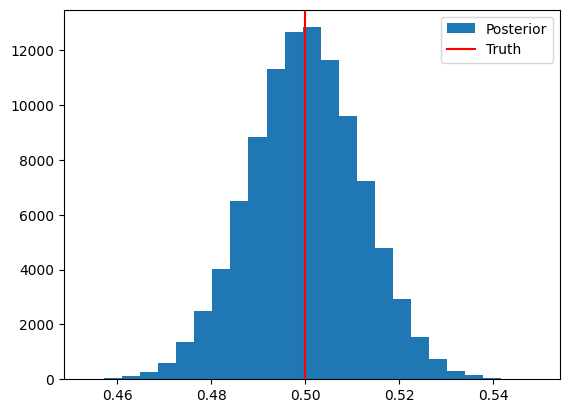

1 sigma deviation using MLEs is =  0.011808409701319411
Mean value is  0.49996130450759985
Comparison to precision estimate from FM =  0.011815990881234828
These agree to within  99.93583966007068 %


In [39]:
plt.hist(MLE_values,bins = 25, label = 'Posterior');
plt.axvline(x = 0.5, c = 'red', label = 'Truth')
plt.legend()
plt.show()
print("1 sigma deviation using MLEs is = ", np.std(MLE_values))
print("Mean value is ", np.mean(MLE_values))
print("Comparison to precision estimate from FM = ", a_ex / np.sqrt(SNR2_w_gaps_regularised))
print("These agree to within ",100*(np.std(MLE_values)/(a_ex / np.sqrt(SNR2_w_gaps_regularised))),'%')

# Check mismodelling formula


## The equation
\begin{equation}
\mathbb{E}_{N}[\widehat{\Delta \theta}^{i}_{\text{bf}}\widehat{\Delta \theta}^{j}_{\text{bf}}] = 2(\Gamma^{-1})_{(\Sigma)}^{ik}   \text{Re}(\partial_{k}\boldsymbol{\hat{H}}^{\dagger}\Sigma^{-1}\Sigma_{N}\Sigma^{-1}\partial_{p}\boldsymbol{\hat{H}})(\Gamma^{-1})_{(\Sigma)}^{pj}\
\end{equation}

Notice that in the case when the model covariance matrix matches the noise covariance matrix derived from the statistical features of the noise, $\Sigma \equiv \Sigma_{N}$, the above simplifies to

\begin{align}
    \mathbb{E}_{N}[\widehat{\Delta \theta}^{i}_{\text{bf}}\widehat{\Delta \theta}^{j}_{\text{bf}}]_{\Sigma = \Sigma_{N}}  
    & = (\Gamma^{-1})_{\Sigma_{N}}^{ij} \, ,\label{eq:FM_gaps}
\end{align}
the predicted covariance on recovered parameters when the noise is gated. This shows that only if the model covariance matrix is consistent with the underlying noise properties, then the statistical fluctuations to parameters induced through noise will be consistent with the $1\sigma$ width of the likelihood function. In our analysis, we will define the quantity $\Upsilon_{ij}$
\begin{equation}\label{eq:comparison_mismodelling_upsilon}
    \Upsilon_{ij} = \frac{(\mathbb{E}_{N}[\widehat{\Delta \theta}^{i}_{\text{bf}}\widehat{\Delta \theta}^{j}_{\text{bf}}])}{(\Gamma^{-1})^{ij}_{\Sigma_{N}}}\, ,
\end{equation}

# Our simplifying case

We can write our signal as $\partial_{a}H = H/a$ and after using the expression $(\Gamma_{aa})^{\Sigma} = \rho^2_{\Sigma} / a^2$, the above formula reduces to 

\begin{equation}
\mathbb{E}_{N}[\widehat{\Delta \theta}^{i}_{\text{bf}}\widehat{\Delta \theta}^{j}_{\text{bf}}] = \frac{2a^2}{\rho^{4}_{\Sigma}}  \text{Re}(\boldsymbol{\hat{H}}^{\dagger}\Sigma^{-1}\Sigma_{N}\Sigma^{-1}\boldsymbol{\hat{H}})\
\end{equation}

We can calculate this below. Let $\Sigma$ stand for the stationary covariance matrix and $\Sigma_{N}$ the true covariance matrix of the gated process

In [44]:
cov_matrix_stat

mis_modelling_matrix = (2 * a_ex**2 /(SNR2_w_gaps_stat_cov**2)) * (
                        np.real(signal_true_gaps_fft.conj() @  
                               cov_matrix_stat_inv @
                               Cov_Matrix_analytical_dict_slow["Cornish"] @
                               cov_matrix_stat_inv
                               @ signal_true_gaps_fft))

# Compute true covariance

gamma_correct_inv = a_ex**2 / SNR2_w_gaps_regularised

Upsilon_aa = mis_modelling_matrix / gamma_correct_inv

print("Mismodelling matrix for amplitude is",Upsilon_aa)

Mismodelling matrix for amplitude is 7726541.43628842


In [41]:
# Check that this works

# Instead of plotting the likelihood over a grid of values, do this analytically.
max_data_sets = 100000
MLE_values_mismodel = []
# Compute unnormalised windowed template
unnormalised_template = h(1,f0_ex, fdot0_ex, t_pad, w_t = w_t)

# Compute positive side fast fourier transform
unnormalised_template_gaps_fft = np.fft.fftshift(np.fft.fft(unnormalised_template))
    
# Copmute denominator, independent of data
denominator = 2*np.real((unnormalised_template_gaps_fft.conj() @ 
               cov_matrix_stat_inv @ 
               unnormalised_template_gaps_fft))

# Pre compute part of numerator. Covariance + signal (unnormalised) is known
post_mult = (cov_matrix_stat_inv @ unnormalised_template_gaps_fft)
                
for seed_number in tqdm(range(0,max_data_sets)):
    
    data_f_gaps_seed = build_data(seed_number, variance_f_dict["Cornish"], w_t)  # Generate gated noise 

    numerator = 2*np.real(np.dot(data_f_gaps_seed.conj(), 
                post_mult)) # Compute numerator


    MLE_values_mismodel.append(numerator/denominator) # Compute MLE

100%|██████████| 100000/100000 [00:27<00:00, 3627.87it/s]


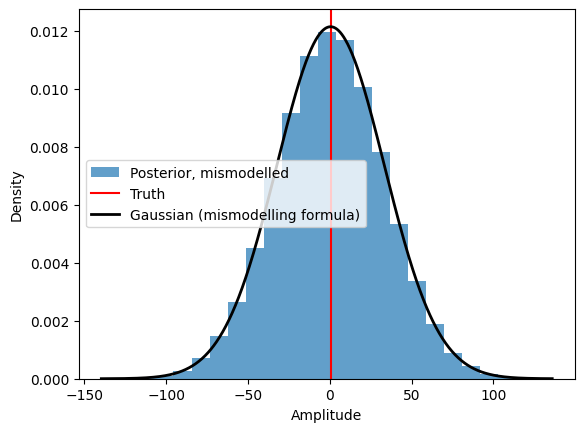

1 sigma deviation using MLEs is =  32.92923738310092
1 sigma deviation using mismodelling formula is =  32.84450463322569
Comparison to precision estimate from FM =  0.011815990881234828


In [46]:
plt.hist(MLE_values_mismodel, bins=25, density=True, alpha=0.7, label='Posterior, mismodelled')
plt.axvline(x=0.5, c='red', label='Truth')

# Plot Gaussian overlay
x_range = np.linspace(min(MLE_values_mismodel), max(MLE_values_mismodel), 1000)
gaussian = (1 / (np.sqrt(2 * np.pi * mis_modelling_matrix))) * np.exp(-0.5 * ((x_range - a_ex)**2) / mis_modelling_matrix)
plt.plot(x_range, gaussian, 'k-', linewidth=2, label='Gaussian (mismodelling formula)')

plt.legend()
plt.xlabel('Amplitude')
plt.ylabel('Density')
plt.show()
print("1 sigma deviation using MLEs is = ", np.std(MLE_values_mismodel))
print("1 sigma deviation using mismodelling formula is = ", np.sqrt(mis_modelling_matrix))
print("Comparison to precision estimate from FM = ", a_ex / np.sqrt(SNR2_w_gaps_regularised))
# print("These agree to within ",100*(np.std(MLE_values_mismodel)/(a_ex / np.sqrt(SNR2_w_gaps_regularised))),'%')